In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nfl_data_py as nfl

print("✅ Libraries loaded successfully!")

✅ Libraries loaded successfully!


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import nfl_data_py as nfl

print("✅ Libraries loaded successfully!")

✅ Libraries loaded successfully!


In [3]:
# Load weekly player data for the 2024 season
data = nfl.import_weekly_data([2024])

print("✅ Data loaded successfully!")
print("Number of rows:", len(data))
print("Columns available:")
print(list(data.columns))

Downcasting floats.
✅ Data loaded successfully!
Number of rows: 5597
Columns available:
['player_id', 'player_name', 'player_display_name', 'position', 'position_group', 'headshot_url', 'recent_team', 'season', 'week', 'season_type', 'opponent_team', 'completions', 'attempts', 'passing_yards', 'passing_tds', 'interceptions', 'sacks', 'sack_yards', 'sack_fumbles', 'sack_fumbles_lost', 'passing_air_yards', 'passing_yards_after_catch', 'passing_first_downs', 'passing_epa', 'passing_2pt_conversions', 'pacr', 'dakota', 'carries', 'rushing_yards', 'rushing_tds', 'rushing_fumbles', 'rushing_fumbles_lost', 'rushing_first_downs', 'rushing_epa', 'rushing_2pt_conversions', 'receptions', 'targets', 'receiving_yards', 'receiving_tds', 'receiving_fumbles', 'receiving_fumbles_lost', 'receiving_air_yards', 'receiving_yards_after_catch', 'receiving_first_downs', 'receiving_epa', 'receiving_2pt_conversions', 'racr', 'target_share', 'air_yards_share', 'wopr', 'special_teams_tds', 'fantasy_points', 'fanta

In [4]:
# Group data by team, season, and week — summing key statistics
team_week = data.groupby(['season', 'week', 'recent_team']).agg({
    'passing_yards': 'sum',
    'rushing_yards': 'sum',
    'receiving_yards': 'sum',
    'passing_tds': 'sum',
    'rushing_tds': 'sum',
    'receiving_tds': 'sum',
    'interceptions': 'sum',
    'rushing_fumbles_lost': 'sum',
    'receiving_fumbles_lost': 'sum',
    'fantasy_points': 'sum'
}).reset_index()

# Create a "total yards" and "total touchdowns" feature
team_week['total_yards'] = (
    team_week['passing_yards'] + 
    team_week['rushing_yards'] + 
    team_week['receiving_yards']
)

team_week['total_tds'] = (
    team_week['passing_tds'] + 
    team_week['rushing_tds'] + 
    team_week['receiving_tds']
)

print("✅ Team-level data created:")
display(team_week.head())

✅ Team-level data created:


,season,week,recent_team,passing_yards,rushing_yards,receiving_yards,passing_tds,rushing_tds,receiving_tds,interceptions,rushing_fumbles_lost,receiving_fumbles_lost,fantasy_points,total_yards,total_tds
0,2024,1,ARI,162.0,124.0,162.0,1,1,1,0.0,0.0,0.0,57.079998,448.0,3
1,2024,1,ATL,155.0,89.0,155.0,1,0,1,2.0,0.0,0.0,36.599998,399.0,2
2,2024,1,BAL,273.0,185.0,273.0,1,1,1,0.0,0.0,0.0,70.720001,731.0,3
3,2024,1,BUF,232.0,130.0,232.0,2,2,2,0.0,0.0,0.0,75.480003,594.0,6
4,2024,1,CAR,161.0,58.0,161.0,0,1,0,2.0,1.0,0.0,28.340000,380.0,1


In [6]:
# Load 2024 schedule (contains game outcomes)
games = nfl.import_schedules([2024])

# Keep only the columns we need
games = games[['game_id', 'week', 'home_team', 'away_team', 'home_score', 'away_score']]

# Add a "winner" column
games['winner'] = np.where(games['home_score'] > games['away_score'], games['home_team'],
                    np.where(games['home_score'] < games['away_score'], games['away_team'], 'TIE'))

print("✅ Game data loaded:")
display(games.head())

✅ Game data loaded:


,game_id,week,home_team,away_team,home_score,away_score,winner
6706,2024_01_BAL_KC,1,KC,BAL,27.0,20.0,KC
6707,2024_01_GB_PHI,1,PHI,GB,34.0,29.0,PHI
6708,2024_01_PIT_ATL,1,ATL,PIT,10.0,18.0,PIT
6709,2024_01_ARI_BUF,1,BUF,ARI,34.0,28.0,BUF
6710,2024_01_TEN_CHI,1,CHI,TEN,24.0,17.0,CHI


In [7]:
# Merge team-level stats with game outcomes
merged = (
    team_week
    .merge(games, left_on=['week', 'recent_team'], right_on=['week', 'home_team'], how='left')
    .merge(games, left_on=['week', 'recent_team'], right_on=['week', 'away_team'], how='left', suffixes=('_home', '_away'))
)

# Clean up: if the team is in the home_team column, use home_score, otherwise away_score
merged['team_score'] = np.where(merged['recent_team'] == merged['home_team_home'], merged['home_score_home'],
                         np.where(merged['recent_team'] == merged['away_team_away'], merged['away_score_away'], np.nan))

# Determine if the team won (1) or lost (0)
merged['win'] = np.where(
    ((merged['recent_team'] == merged['winner_home']) | (merged['recent_team'] == merged['winner_away'])),
    1, 0
)

# Drop duplicate or unneeded columns
final_df = merged[['season', 'week', 'recent_team', 'total_yards', 'total_tds', 'interceptions', 'rushing_fumbles_lost', 'win']]

print("✅ Merged data sample:")
display(final_df.head())

✅ Merged data sample:


,season,week,recent_team,total_yards,total_tds,interceptions,rushing_fumbles_lost,win
0,2024,1,ARI,448.0,3,0.0,0.0,0
1,2024,1,ATL,399.0,2,2.0,0.0,0
2,2024,1,BAL,731.0,3,0.0,0.0,0
3,2024,1,BUF,594.0,6,0.0,0.0,1
4,2024,1,CAR,380.0,1,2.0,1.0,0


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define feature columns (you can adjust these later)
features = [
    'passing_yards', 'rushing_yards', 'receiving_yards',
    'passing_tds', 'rushing_tds', 'receiving_tds',
    'interceptions', 'rushing_fumbles_lost', 'fantasy_points'
]

target = 'win'

# Drop any rows with missing data
team_week_model = team_week.dropna(subset=features + [target])

# Split data into features (X) and target (y)
X = team_week_model[features]
y = team_week_model[target]

# Split into train (70%) and test (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale features (important for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"✅ Data ready for modeling!")
print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

✅ Data ready for modeling!
Training samples: 3571
Testing samples: 1531


📊 Logistic Regression Results:
Accuracy: 0.589
AUC: 0.605
Confusion Matrix:
[[229 441]
 [188 673]]

🌲 Random Forest Results:
Accuracy: 0.637
AUC: 0.666
Confusion Matrix:
[[392 278]
 [278 583]]


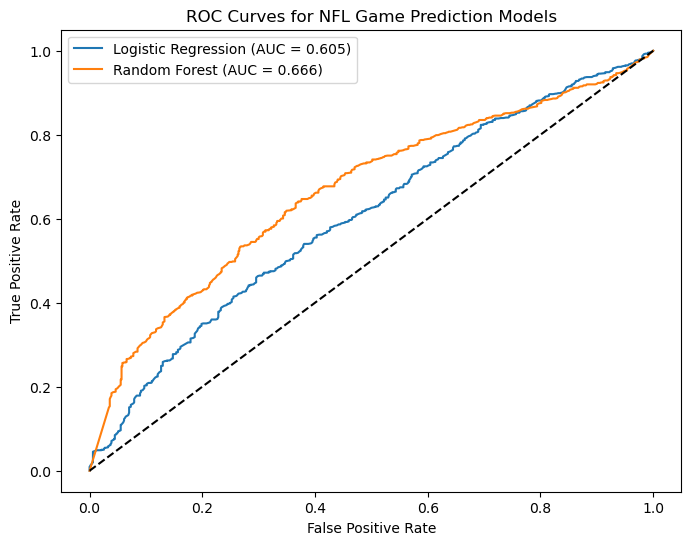

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# --- Logistic Regression ---
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train_scaled, y_train)
y_pred_log = log_model.predict(X_test_scaled)
y_prob_log = log_model.predict_proba(X_test_scaled)[:, 1]

log_acc = accuracy_score(y_test, y_pred_log)
log_auc = roc_auc_score(y_test, y_prob_log)

print("📊 Logistic Regression Results:")
print(f"Accuracy: {log_acc:.3f}")
print(f"AUC: {log_auc:.3f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_log))

# --- Random Forest ---
rf_model = RandomForestClassifier(n_estimators=200, max_depth=None, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

rf_acc = accuracy_score(y_test, y_pred_rf)
rf_auc = roc_auc_score(y_test, y_prob_rf)

print("\n🌲 Random Forest Results:")
print(f"Accuracy: {rf_acc:.3f}")
print(f"AUC: {rf_auc:.3f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

# --- ROC Curve Visualization ---
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.figure(figsize=(8,6))
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {log_auc:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {rf_auc:.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for NFL Game Prediction Models")
plt.legend()
plt.show()

In [16]:
team_week_model.shape[0]

5102

In [17]:
len(team_week)

5102

In [18]:
len(team_week_model)

5102